# Project: Generating Differentially Private Labels for the Digits data set

As we seen in the lectures, we can use the predictions from others classifiers to approximate the labels on our own data set (assuming it is unlabeled). This mechanism will allow us to guarantee the privacy safety from the individuals on the external data sets. However, this method could potentially leak some information if one individual have its data overlapped with more than two external data sets. In this project we will simulate this setting.

## Libraries

In [1]:
from helper_01 import *
import warnings
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
sns.set()
np.random.seed(5)
torch.manual_seed(5)

# Phase One: The data set

For the data set, we will use the digits data. This data set will be randomly divided into eleven subsets. The first ten will be used to train the classifiers. The remaining one will be used to train our pytorh model.

## Data generation

In [2]:
# creates the remote data sets.
remote_datasets, X, y_true = generate_data(shuffle = True)

In [2]:
# creates the remote data sets.
remote_datasets, X, y_true = generate_data(shuffle = True)

In [3]:
remote_datasets[9]

{'data': array([[ 0.,  0.,  2., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  0., ..., 15.,  7.,  0.],
        ...,
        [ 0.,  0.,  4., ...,  7.,  0.,  0.],
        [ 0.,  1., 11., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'labels': array([7, 0, 9, 0, 6, 2, 2, 5, 7, 5, 9, 1, 6, 0, 4, 2, 9, 0, 3, 9, 3, 9,
        0, 1, 8, 2, 3, 8, 9, 6, 4, 4, 1, 5, 5, 9, 4, 0, 9, 1, 2, 6, 2, 7,
        5, 1, 7, 6, 6, 8, 2, 7, 3, 0, 0, 2, 1, 9, 8, 6, 7, 9, 1, 5, 0, 9,
        3, 6, 3, 0, 7, 4, 5, 6, 4, 6, 5, 9, 8, 9, 8, 9, 5, 2, 4, 7, 9, 1,
        7, 5, 9, 7, 4, 3, 2, 1, 3, 2, 0, 0, 8, 7, 2, 7, 2, 4, 9, 2, 7, 0,
        0, 5, 4, 5, 5, 8, 7, 9, 5, 4, 9, 0, 9, 9, 7, 6, 5, 6, 9, 9, 6, 2,
        8, 9, 6, 0, 2, 9, 1, 4, 7, 4, 5, 6, 5, 2, 0, 6, 1, 8, 7, 3, 1, 4,
        8, 0, 3, 4, 4, 9, 0, 3, 4])}

## Plots

Now we will plot some samples from the data set.

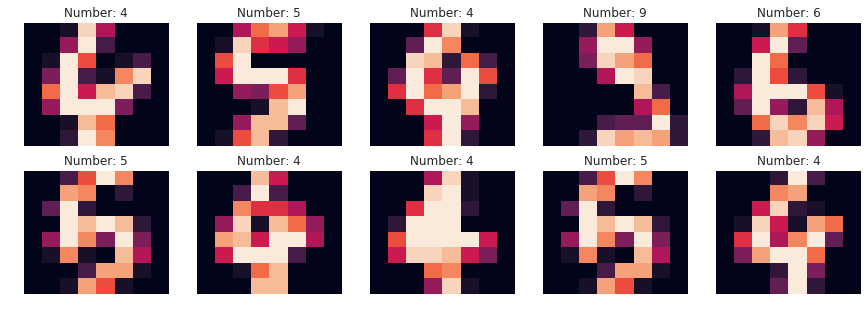

In [6]:
plot_digits(X, y_true)

# Phase Two: Training external classifiers

Next, we train ten classifiers in each data subset. As we can see almost all the classifiers get a higher accuracy, except Ada Boost. This can be improved, however, to maintain results reproducible, we let the classifiers with a default set of configurations.

In [8]:
classifiers = train_classifiers(remote_datasets)

[1] - AdaBoostClassifier classifier | accuracy: 0.24539877300613497
[2] - RandomForestClassifier classifier | accuracy: 1.0
[3] - KNeighborsClassifier classifier | accuracy: 0.9631901840490797
[4] - MLPClassifier classifier | accuracy: 1.0
[5] - DecisionTreeClassifier classifier | accuracy: 1.0
[6] - SVC classifier | accuracy: 0.9877300613496932
[7] - GradientBoostingClassifier classifier | accuracy: 1.0
[8] - SGDClassifier classifier | accuracy: 1.0
[9] - LogisticRegression classifier | accuracy: 1.0
[10] - RidgeClassifier classifier | accuracy: 0.9754601226993865


# Phase Three: Generate predictions to our local data set

Now, we will use the trained classifiers to generate a set of labels on our local data set. As we can see, we obtain an array of numbers from zero to nine.

In [74]:
preds = generate_predictions(X, classifiers)

In [75]:
preds

array([[1., 6., 6., ..., 6., 6., 6.],
       [1., 9., 9., ..., 9., 9., 9.],
       [1., 9., 9., ..., 9., 9., 9.],
       ...,
       [1., 6., 6., ..., 6., 6., 6.],
       [1., 8., 2., ..., 2., 8., 9.],
       [1., 3., 3., ..., 3., 3., 3.]])

Next, we will generate our labels using the Laplacian mechanism. In this setting, we choose epsilon to be 0.1.

In [8]:
new_labels = generate_labels(preds, epsilon = 0.1)

In [9]:
new_labels[0:10]

[2, 9, 3, 6, 4, 1, 4, 1, 6, 3]

We now have our labels ready. In the next pahse we will create a custom network to use the generated labels.

# Phase Four: Define our Local Model

We will use a neural network composed by three layers. This model will take as inputs the images in their vector form. To calculate the output we will use a softmax layer, where a logarithm is applied to smooth the resulting vector.

![](../plots/model_d20.png)

```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 50)
        self.fc2 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.output(x), dim = 1)
        return x
```

## Training

Next, we will train our model. Here ADAM and NLLLoss are being used as optimizer and criterion. Also, for ADAM we set the learning rate to 0.01. Finally, this model will train for 50 epochs.

In [10]:
model = Net()
# optimizer
op = optim.Adam(model.parameters(), lr = 0.01)
# criterion
criterion = nn.NLLLoss()
# convert labels
labels = np.array(new_labels)
ylabels = torch.tensor(labels.astype(float), requires_grad = True).long()
# train
model = train_model(model, X, ylabels, op, criterion, 50)

Epoch: 1 | 50, loss: 2.44927716255188
Epoch: 2 | 50, loss: 2.3585829734802246
Epoch: 3 | 50, loss: 2.226154327392578
Epoch: 4 | 50, loss: 2.1533164978027344
Epoch: 5 | 50, loss: 2.09911847114563
Epoch: 6 | 50, loss: 2.0479061603546143
Epoch: 7 | 50, loss: 1.9901325702667236
Epoch: 8 | 50, loss: 1.918312668800354
Epoch: 9 | 50, loss: 1.838196039199829
Epoch: 10 | 50, loss: 1.7651565074920654
Epoch: 11 | 50, loss: 1.6951661109924316
Epoch: 12 | 50, loss: 1.6280966997146606
Epoch: 13 | 50, loss: 1.5513769388198853
Epoch: 14 | 50, loss: 1.4773941040039062
Epoch: 15 | 50, loss: 1.3933188915252686
Epoch: 16 | 50, loss: 1.302552580833435
Epoch: 17 | 50, loss: 1.2124255895614624
Epoch: 18 | 50, loss: 1.132278561592102
Epoch: 19 | 50, loss: 1.0592623949050903
Epoch: 20 | 50, loss: 0.9800019264221191
Epoch: 21 | 50, loss: 0.881312906742096
Epoch: 22 | 50, loss: 0.7940284609794617
Epoch: 23 | 50, loss: 0.7312641739845276
Epoch: 24 | 50, loss: 0.6520299911499023
Epoch: 25 | 50, loss: 0.56602936983

## Calculate Accuracy

In [11]:
calculate_accuracy(model, X, ylabels)

Accuracy: 1.0


1.0

# Phase Five: Experiment, varying epsilon

In this phase, we will see how the different values of epsilon affect both: the accuracy over the real labels and the generated ones. For that purpose, we will define a set of epsilons to explore.

In [12]:
epsilons = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1, 1e+2, 10e+3]

Now, we will train our local model from zero on the generated labels using 50 epochs. In this case we will made a single run.

In [13]:
y_single, p_single = run_experiment(epsilons, X, y_true, preds, epochs = 50)

Epsilon: 1e-05 | Accuracy on real labels: 0.09580838323353294 | Accuracy on generated labels: 1.0
Epsilon: 0.0001 | Accuracy on real labels: 0.12574850299401197 | Accuracy on generated labels: 1.0
Epsilon: 0.001 | Accuracy on real labels: 0.09580838323353294 | Accuracy on generated labels: 1.0
Epsilon: 0.01 | Accuracy on real labels: 0.1317365269461078 | Accuracy on generated labels: 0.9520958083832335
Epsilon: 0.1 | Accuracy on real labels: 0.15568862275449102 | Accuracy on generated labels: 1.0
Epsilon: 1 | Accuracy on real labels: 0.844311377245509 | Accuracy on generated labels: 1.0
Epsilon: 10.0 | Accuracy on real labels: 0.9041916167664671 | Accuracy on generated labels: 1.0
Epsilon: 100.0 | Accuracy on real labels: 0.8982035928143712 | Accuracy on generated labels: 1.0
Epsilon: 10000.0 | Accuracy on real labels: 0.8922155688622755 | Accuracy on generated labels: 1.0


We can see that, the more epsilon increases the more our model approaches the real labels. Next, lets repeat this experiment, but now, lets average the results using 20 runs.

In [3]:
10e+3

10000.0

In [13]:
y_avg, p_avg = run_experiment_avg(epsilons, X, y_true, preds, average = 20, epochs = 50)

Epsilon: 1e-05 | Avg accuracy on real labels: 0.09940119760479042 | Avg Accuracy on generated labels: 0.9934131736526947
Epsilon: 0.0001 | Avg accuracy on real labels: 0.09940119760479042 | Avg Accuracy on generated labels: 0.9991017964071857
Epsilon: 0.001 | Avg accuracy on real labels: 0.10449101796407186 | Avg Accuracy on generated labels: 0.9994011976047904
Epsilon: 0.01 | Avg accuracy on real labels: 0.11646706586826347 | Avg Accuracy on generated labels: 0.9934131736526947
Epsilon: 0.1 | Avg accuracy on real labels: 0.21646706586826342 | Avg Accuracy on generated labels: 0.9979041916167665
Epsilon: 1 | Avg accuracy on real labels: 0.9239520958083833 | Avg Accuracy on generated labels: 1.0
Epsilon: 10.0 | Avg accuracy on real labels: 0.9497005988023954 | Avg Accuracy on generated labels: 1.0
Epsilon: 100.0 | Avg accuracy on real labels: 0.9502994011976049 | Avg Accuracy on generated labels: 1.0
Epsilon: 10000.0 | Avg accuracy on real labels: 0.9485029940119762 | Avg Accuracy on ge

Interesting, we see the same behavior. This correlates with the discuss of class about the trade-off of choosing a right value to epsilon. Finally, lets compare the results from a single and an average run.

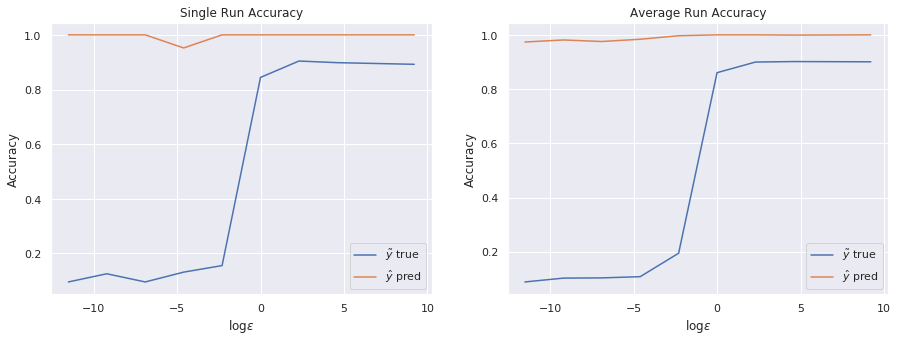

In [15]:
comparison_plot(epsilons, [y_single, p_single], [y_avg, p_avg], 'avg_comparison')

As we can see, there is a point were we totally approximate the real values from the labels. Again, this suggest that, the value for epsilon must be careful considered when applying this mechanism.

# Phase six: Training classifiers multiple times

From the previous results, we can conclude that, in fact, increasing epsilon will lead to data leaks. In this phase, we will give a last try to see if this is true. However, this time we will repeat the process training also the classifiers.

In [14]:
# Note: This could take a little longer
training = 10 # train 10 different times
for train in range(training):
    classifiers = train_classifiers(remote_datasets, print_results = False)
    preds = generate_predictions(X, classifiers)
    y_single, p_single = run_experiment(epsilons, X, y_true, preds, epochs = 50, print_results = False)
    y_avg, p_avg = run_experiment_avg(epsilons, X, y_true, preds, average = 20, epochs = 50, print_results = False)

/home/antonio/anaconda3/envs/dlnd/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/antonio/anaconda3/envs/dlnd/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/antonio/anaconda3/envs/dlnd/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/antonio/anaconda3/envs/dlnd/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/antonio/anaconda3/envs/dlnd/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarni

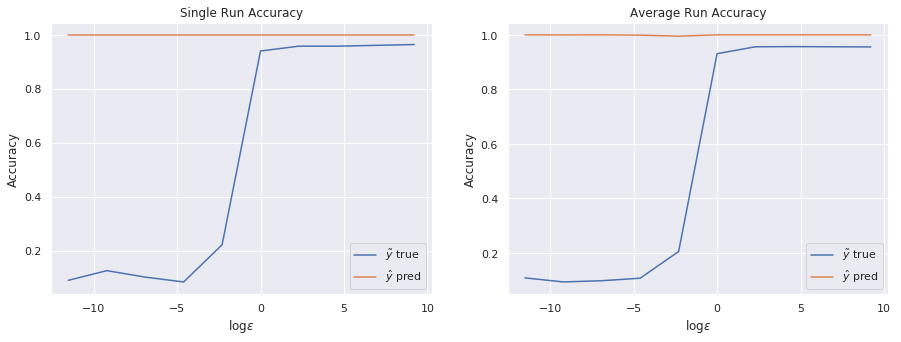

In [15]:
# Plot time
comparison_plot(epsilons, [y_single, p_single], [y_avg, p_avg], 'classifiers_comparison')

Well, even training the classifier each time, it seems that, the results are quite similar. However, I think this is related with the size of the data set (it is quite smaller). I theorize that in with bigger data, we could observe some changes here.

# Phase seven: PATE Analysis

In this section, we will apply the PATE analysis over the generated labels.

In [16]:
from syft.frameworks.torch.differential_privacy import pate

## Varying delta

In [126]:
# Note that, this section needs the preds result from the Phase Three: Generate predictions to our local data set
pate.perform_analysis(teacher_preds = preds.T.astype(int), indices = y_true.numpy().astype(int), noise_eps = .1, delta = 1e-5)

(15.776462732485108, 15.776462732485115)

In [127]:
# Note that, this section needs the preds result from the Phase Three: Generate predictions to our local data set
pate.perform_analysis(teacher_preds = preds.T.astype(int), indices = y_true.numpy().astype(int), noise_eps = .1, delta = 1e-6)

(16.927755278982133, 16.92775527898214)

In [128]:
# Note that, this section needs the preds result from the Phase Three: Generate predictions to our local data set
pate.perform_analysis(teacher_preds = preds.T.astype(int), indices = y_true.numpy().astype(int), noise_eps = .1, delta = 1e-7)

(18.079047825479154, 18.07904782547916)

We can see how the results vary with each change in delta.

## Varying predictions

In the lesson we also see that some changes in the values from the predictions can affect the results.

In [129]:
# pate analysis with 100 teachers
num_teachers, num_examples, num_labels = (100, 100, 10)
p = (np.random.rand(num_teachers, num_examples) * num_labels).astype(int)
indices = (np.random.rand(num_examples) * num_labels).astype(int)
pate.perform_analysis(teacher_preds = p, indices = indices, noise_eps = .1, delta = 1e-5)

(11.756462732485105, 11.756462732485115)

In [130]:
# changing predictions, this will have an impact over epsilon
p[:, 0:5] *= 0
pate.perform_analysis(teacher_preds = p, indices = indices, noise_eps = .1, delta = 1e-5)

(8.42373882359225, 11.756462732485115)

Here, we will change our prediction and see the results.

In [131]:
# Change the values from two teachers to the class 0
preds[:, 5: 7] = 0

In [132]:
# next, lets repeat the pate analysis
pate.perform_analysis(teacher_preds = preds.T.astype(int), indices = y_true.numpy().astype(int), noise_eps = .1, delta = 1e-5)

(15.776462732485108, 15.776462732485115)

In [133]:
# Note that, this section needs the preds result from the Phase Three: Generate predictions to our local data set
pate.perform_analysis(teacher_preds = preds.T.astype(int), indices = y_true.numpy().astype(int), noise_eps = .1, delta = 1e-6)

(16.927755278982133, 16.92775527898214)

In [134]:
# Note that, this section needs the preds result from the Phase Three: Generate predictions to our local data set
pate.perform_analysis(teacher_preds = preds.T.astype(int), indices = y_true.numpy().astype(int), noise_eps = .1, delta = 1e-7)

(18.079047825479154, 18.07904782547916)

The results here do not shown any change in epsilons (dependent and independent). However if we run this experiment using the code from class, we get the desired behavior.

## Varying the number of teachers

So, why our epsilon vairs have too small variations?. The answer lies in the number of teahcers. Since in this example we are using 100 teachers, varying the results in the prediction will greatly affect the results. However if we set the teacher to 10 (as in our project), the resuling epsilons will not change.

In [135]:
# Using 10 teachers
num_teachers, num_examples, num_labels = (10, 100, 10)
p = (np.random.rand(num_teachers, num_examples) * num_labels).astype(int)
indices = (np.random.rand(num_examples) * num_labels).astype(int)

In [136]:
pate.perform_analysis(teacher_preds = p, indices = indices, noise_eps = .1, delta = 1e-5)

(11.756462732485105, 11.756462732485115)

In [137]:
p[:, 0:5] *= 0
pate.perform_analysis(teacher_preds = p, indices = indices, noise_eps = .1, delta = 1e-5)

(11.756462732485105, 11.756462732485115)

# Conclusions

This project have been very interesting, not only it allow me to implement the concepts from the Lessons. But also help me to understand the process of applying DP in a data set. I think that, in a scenario with more data, these results can vary. However, this techniques can guarantee the privacy of the data, independently of the data size. Although I observed some different behaviors from the PATE analysis. I was able to see the relationship between the number of teachers and sensitivity in the PATE analysis. Finally, I will continue working on this project, adding more privacy techniques.